## DIstributed Shared Nearest Neighbor experiments

In [72]:
if length(workers()) > 1
    println("Removing previous workers...")
    rmprocs(workers())
end


include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
# Grancoloso
#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",])
#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",
#        "158.251.93.5:3304","158.251.93.5:3303","158.251.93.5:3302","158.251.93.5:3301",])

# Coloso
#addprocs(["158.251.88.180:3301","158.251.88.180:3302","158.251.88.180:3303","158.251.88.180:3304",])

overall_parameters = DSNN_IO.read_configuration("src/experiments_config");
addprocs(overall_parameters["master.nodelist"]);


@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_KNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_SNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_Master.jl")

using Graphs
using CSV

assert(length(workers()) == length(overall_parameters["master.nodelist"]))

Removing previous workers...


stdin: is not a tty
stdin: is not a tty
stdin: is not a tty
stdin: is not a tty
 at /root/.julia/v0.6/Graphs/src/common.jl:13 overwritten at /root/.julia/v0.6/Graphs/src/common.jl:17.
 at /root/.julia/v0.6/Graphs/src/common.jl:61.
 overwritten})( at /root/.julia/v0.6/Graphs/src/common.jl:84Int64.
, K) in module Graphs at /root/.julia/v0.6/Graphs/src/common.jl:13 overwritten at /root/.julia/v0.6/Graphs/src/common.jl:17.
 in module Graphs at /root/.julia/v0.6/Graphs/src/common.jl:124 overwritten at /root/.julia/v0.6/Graphs/src/common.jl:128.
 at /root/.julia/v0.6/Graphs/src/breadth_first_visit.jl:111.


## Execution of the method

In [95]:
overall_parameters = DSNN_IO.read_configuration("src/experiments_config");
results = Dict{String,Any}();
DATA_PATH = overall_parameters["master.inputpath"];
DATA_LEN, DATA_DIM = DSNN_IO.get_dimensions_from_input_file(DATA_PATH);
partitions = DSNN_Master.generate_partitions(length(workers()), DATA_LEN); # N must be extracted from the data.

println("\n***********************************************************")
DSNN_Master.start(results, DATA_PATH, partitions, overall_parameters);
#storing final result
writedlm(@sprintf("%s.dsnnfinal.labels",DATA_PATH), results["stage2_labels"], "\n");


***********************************************************
[M] Starting Stage 1 (assignment distribution and corepoint identification)
	From worker 61:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 59:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 60:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 58:	[W] executing snn clustering with eps:0.9 and minpts:13
[M] Joining worker's results of Stage 1
Amount of noisy data points detected by worker 4:344
Amount of noisy data points detected by worker 2:415
Amount of noisy data points detected by worker 3:403
Amount of noisy data points detected by worker 5:453
[M] Corepoints (235) and Samples (897)
[M] Grouping selected corepoints and sampled data by extracting Connected components


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Int64}, ::Int64) at ./deprecated.jl:57
 [3] Type at /root/.julia/v0.6/Graphs/src/graph_visit.jl:44 [inlined]
 [4] connected_components(::Graphs.GenericAdjacencyList{Int64,UnitRange{Int64},Array{Array{Int64,1},1}}) at /root/.julia/v0.6/Graphs/src/connected_components.jl:20
 [5] start(::Dict{String,Any}, ::String, ::Array{Int64,1}, ::Dict{String,Any}) at /workspace/distributed_clustering/julia/src/dsnn_Master.jl:129
 [6] include_string(::String, ::String) at ./loading.jl:515
 [7] include_string(::Module, ::String, ::String) at /root/.julia/v0.6/Compat/src/Compat.jl:478
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /root/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /root/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[95], in expression starting on line 8


[M] Retransmitting overall corepoints (Stage 2)...
	From worker 58:	[W] Labeling assigned instances from the overall corepoints
	From worker 60:	[W] Labeling assigned instances from the overall corepoints
	From worker 61:	[W] Labeling assigned instances from the overall corepoints
	From worker 59:	[W] Labeling assigned instances from the overall corepoints
[M] Joining Worker's results of Stage 2.
[M] Generating worker's final labelings...


In [ ]:
# Experimentation over the obtained corepoints
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=true);
real_labels = vec(readdlm(@sprintf("%s.labels",DATA_PATH), Int32));
Dw = D[:,results["stage1_corepoints"]];
cp_real_labels = real_labels[results["stage1_corepoints"]];

CSV.write(@sprintf("%s.corepoints.csv",DATA_PATH), DataFrames.DataFrame(full(transpose(Dw))), delim=' ',  header=false);
writedlm(@sprintf("%s.corepoints.labels",DATA_PATH), cp_real_labels, "\n");

snnmat, knnmat = DSNN_KNN.get_snnsimilarity(Dw, overall_parameters["corepoint.knn"], l2knng_path=overall_parameters["l2knng.path"]);

adj_mat = snnmat;
if overall_parameters["corepoint.use_snngraph"]
    snngraph = DSNN_KNN.get_snngraph(knnmat, snnmat);
    adj_mat = snngraph;
end

# Applying SNN-Clustering overthe corepoints
@time begin
    println("Applying SNN-Clustering over the corepoints...");
    cp_results = DSNN_SNN.snn_clustering(overall_parameters["corepoint.eps"], overall_parameters["corepoint.minpts"], adj_mat);

    labels_found = fill(0, size(cp_results["labels"],1));
    for c in collect(1:size(cp_results["labels"],2))
        for i in cp_results["labels"][:,c].nzind
            labels_found[i] = cp_results["clusters"][c]; # extract the right assigned label name
        end
    end

    println("Num. Clusters found:",length(unique(labels_found)))
    if length(find(x->x<0, cp_results["clusters"])) > 0
        println(@sprintf("Percentage of noise:: %0.2f", 
                length(cp_results["labels"][:,1].nzind)/size(cp_results["labels"],1)))
    else
        println("Amount of noise: 0");
    end
    writedlm(@sprintf("%s.corepoints.snn.labels",DATA_PATH), labels_found, "\n");
end

# Applying Connected components
@time begin
    println("Applying Connected Components over the corepoints...");
    numpoints = size(Dw,2);
    println("Num. points:",numpoints);

    G = Graphs.simple_adjlist(numpoints, is_directed=false);
    for i in collect(1:numpoints)
        for j in adj_mat[:,i].nzind
            Graphs.add_edge!(G, i, j)
        end
    end

    cmps = Graphs.connected_components(G);

    println("Num. connected components:",length(cmps));
    labels_found = fill(-1, numpoints);
    for cmp_i in eachindex(cmps)
        for p in cmps[cmp_i]
            labels_found[p] = cmp_i;
        end
    end
    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.conncomps.labels",DATA_PATH), labels_found, "\n");

end

# Applying Maximal Clique to the corepoints
@time begin
    println("Applying Maximal Clique over the corepoints...");
    numpoints = size(Dw,2);
    println("Num. points:",numpoints);

    G = Graphs.simple_adjlist(numpoints, is_directed=false);
    for i in collect(1:numpoints)
        for j in adj_mat[:,i].nzind
            Graphs.add_edge!(G, i, j)
        end
    end

    cmps = Graphs.maximal_cliques(G);

    println("Num. Cliques:",length(cmps));
    labels_found = fill(-1, numpoints);
    for cmp_i in eachindex(cmps)
        for p in cmps[cmp_i]
            labels_found[p] = cmp_i;
        end
    end

    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.cliques.labels",DATA_PATH), labels_found, "\n");

end

# Applying Label propagation to the corepoints
@time begin
    println("Applying Label propagation over the corepoints...")
    using LightGraphs

    G = LightGraphs.Graph(numpoints)
    for i in collect(1:numpoints)
       for j in adj_mat[:, i].nzind
           if j > i 
               # maybe a threshold based on adj_mat[j,i] could be used !
               if ~LightGraphs.add_edge!(G, i, j)
                   println("[M] Error: Cannot add edge between vertices ",i," and ",j)
               end
           end
       end
    end
    labels_found, conv_history = LightGraphs.label_propagation(G);
    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.lblprop.labels",DATA_PATH), labels_found, "\n");

end


# Applying DBSCAN over the corepoints
@time begin
    println("Applying DBSCAN over the corepoints...");
    using Clustering

    #dbscan_cl = Clustering.dbscan(full(Dw), 0.1, min_neighbors=15);
    dbscan_cl = Clustering.dbscan(full(1.0 .- adj_mat), overall_parameters["corepoint.dbscan.eps"], overall_parameters["corepoint.dbscan.minpts"]);
    labels_found = dbscan_cl.assignments;
    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.dbscan.labels",DATA_PATH), labels_found, "\n");
end

In [97]:
println("\n########################################################\n")
run(`python src/evaluate_corepoint_files.py -i $DATA_PATH -f rst`)


########################################################

Evaluating over corepoints generated from data file /workspace/cure_large.dat
===================  ==========  ==========  =========
Method                  V-Score         ARI        AMI
===================  ==========  ==========  =========
D-SNN (all)          0.00410386  0.00530457  0.0024327
SNN (cpts)           0.323212    0.00780996  0.0538638
Conn. Comps. (cpts)  0.506811    0.422566    0.33391
Max Cliques (cpts)   0.349137    0.0371718   0.145055
Label Prop. (cpts)   0.465236    0.139756    0.313294
DBSCAN (cpts)        0.737053    0.713989    0.604203
===================  ==========  ==========  =========


[Only for small 2D data] Plotting corepoints and whole dataset



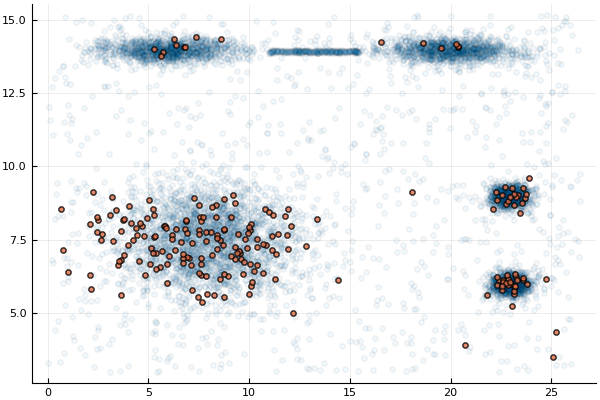

In [88]:
if size(Dw,1) == 2
    println("[Only for small 2D data] Plotting corepoints and whole dataset")
    using Plots
    pyplot()
    D_raw = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);

    colors = fill(1, size(D,2));
    colors[results["stage1_corepoints"]] = 2;
    plt = scatter(D_raw[1,:], D_raw[2,:], marker=(0.05,:o,4), legend=false, fmt = :png)
    scatter!(plt, D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], marker=(0.8,:o,4), legend=false, fmt = :png)
end

opening snn
opening conncomps
opening cliques
opening lblprop
opening dbscan



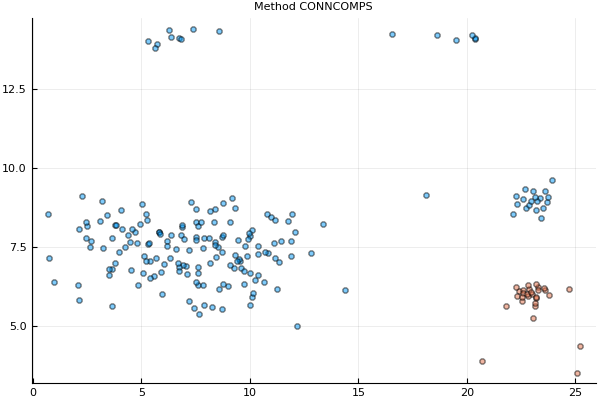

In [89]:
l_methods = ["snn", "conncomps", "cliques", "lblprop", "dbscan"];
labels_found = fill(-1, (size(Dw,2),length(l_methods)));
for meth_i in collect(1:length(l_methods))
    meth = l_methods[meth_i];
    println("opening ",meth)
    labels_found[:,meth_i] = vec(readdlm(@sprintf("%s.corepoints.%s.labels",DATA_PATH, meth), Int32));
end

#Plots.scatter(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], marker=(0.5,:o,4), group=labels_found[:,1], legend=false, fmt = :png, title=@sprintf("Method %s", uppercase("snn")))
Plots.scatter(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,2], legend=false, fmt = :png, title=@sprintf("Method %s", uppercase("conncomps")))
#Plots.scatter(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,3], legend=false, fmt = :png, title=@sprintf("Method %s", uppercase("cliques")))
#Plots.scatter(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,4], legend=false, fmt = :png, title=@sprintf("Method %s", uppercase("lblprop")))
#Plots.scatter(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,5], legend=false, fmt = :png, title=@sprintf("Method %s", uppercase("dbscan")))


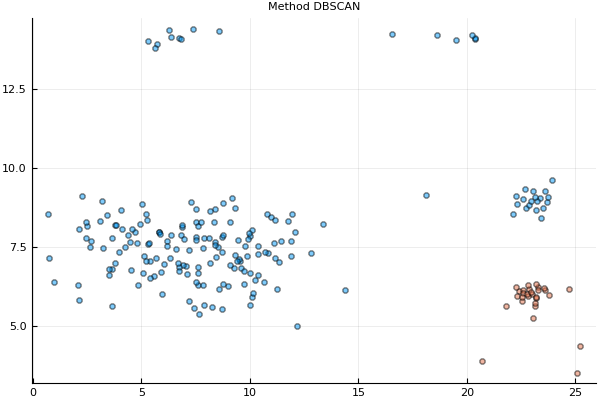

In [90]:
Plots.scatter(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,5], legend=false, fmt = :png, title=@sprintf("Method %s", uppercase("dbscan")))

The _start_ method sets the value of the dictionary _results_ by adding the following values:

* stage1_corepoints: Union of all corepoints identified by the Workers.
* stage1_sampled: Union of all the data points sampled by the Workers.
* stage1_graph: SNN Graph built with __all__ the data returned by the Workers.
* stage2_labels: Labels generated by the Workers after _stage 2_.

## Final result

Showing only non-noise points (6299/8100)



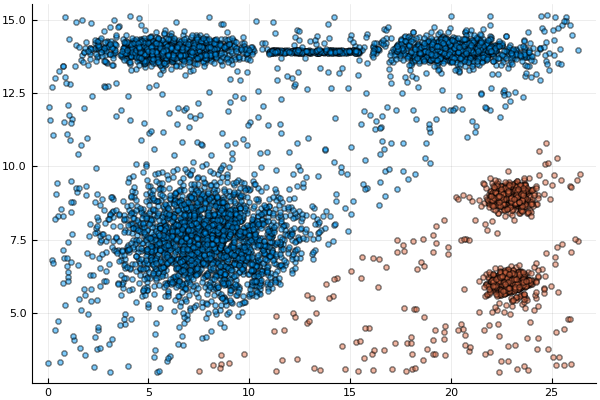

In [52]:
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
nonnoise = find(x->x>0,results["stage2_labels"]);
println(@sprintf("Showing only non-noise points (%d/%d)",length(nonnoise),size(D,2)))
plt = scatter(D[1,nonnoise], D[2,nonnoise], marker=(0.5,:o,4), group=results["stage2_labels"][nonnoise], legend=false, fmt = :png)

In [98]:
?writedlm

search: writedlm



```
writedlm(f, A, delim='\t'; opts)
```

Write `A` (a vector, matrix, or an iterable collection of iterable rows) as text to `f` (either a filename string or an `IO` stream) using the given delimiter `delim` (which defaults to tab, but can be any printable Julia object, typically a `Char` or `AbstractString`).

For example, two vectors `x` and `y` of the same length can be written as two columns of tab-delimited text to `f` by either `writedlm(f, [x y])` or by `writedlm(f, zip(x, y))`.


### ... END of grouping over corepoints